# Deep Learning (Dense Neural Network )

## Setup

In [154]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.utils import class_weight

import tensorflow as tf
from tensorflow import keras
from keras import layers

### Data Setup

In [155]:
# Read dataset and create training an validation datasets
training_set = pd.read_csv('../Data/train.csv')
training_set = training_set.drop(columns=["id"])
training_set["defects"] = [1 if value else 0 for value in training_set["defects"].values]


In [156]:
true_data = training_set[training_set["defects"].values == True]
false_data = training_set[training_set["defects"].values == False]

true_feature_data = true_data.drop(columns=["defects"])
false_feature_data = false_data.drop(columns=["defects"])

true_train_proportion = 0.5
false_train_proportion = true_train_proportion * len(true_feature_data) / len(false_feature_data)

true_X_train, true_X_validation, true_Y_train, true_Y_validation = train_test_split(true_feature_data, true_data["defects"], test_size=(1-true_train_proportion))
false_X_train, false_X_validation, false_Y_train, false_Y_validation = train_test_split(false_feature_data, false_data["defects"], test_size=(1-false_train_proportion))

X_train = pd.concat([true_X_train, false_X_train])
X_validation = pd.concat([true_X_validation, false_X_validation])
Y_train = pd.concat([true_Y_train, false_Y_train])
Y_validation = pd.concat([true_Y_validation, false_Y_validation])

In [157]:
X_train = X_train.to_numpy().tolist()
X_validation = X_validation.to_numpy().tolist()
Y_train = Y_train.to_numpy().tolist()
Y_validation = Y_validation.to_numpy().tolist()

## Model Creation

### Model Architecture

In [158]:
def build_model():

    inputs = keras.Input(shape=(21))
    x = inputs
    
    x = layers.Dense(32, activation="relu")(x)
    x = layers.Dropout(0.3)(x)

    x = layers.Dense(64, activation="relu")(x)
    x = layers.Dropout(0.5)(x)

    x = layers.Dense(128, activation="relu")(x)
    x = layers.Dropout(0.3)(x)

    x = layers.Dense(64, activation="relu")(x)
    x = layers.Dropout(0.3)(x)

    x = layers.Dense(32, activation="relu")(x)
    x = layers.Dropout(0.1)(x)

    x = layers.Dense(8, activation="relu")(x)
    x = layers.Dropout(0.1)(x)

    x = layers.Dense(1, activation="sigmoid")(x)

    outputs = x
    model = keras.Model(inputs=inputs, outputs=outputs)

    return model

# Define model's architecture
model = build_model()

# Print model's architecture
model.summary()


Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 21)]              0         
                                                                 
 dense_26 (Dense)            (None, 32)                704       
                                                                 
 dropout_21 (Dropout)        (None, 32)                0         
                                                                 
 dense_27 (Dense)            (None, 64)                2112      
                                                                 
 dropout_22 (Dropout)        (None, 64)                0         
                                                                 
 dense_28 (Dense)            (None, 128)               8320      
                                                                 
 dropout_23 (Dropout)        (None, 128)               0   

### Model Training

In [178]:
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(training_set["defects"]), y=training_set["defects"])

class_weight_dict = {}
for i in range(len(class_weights)):
    class_weight_dict[i] = class_weights[i]
    
print("Training class weights:", class_weight_dict)

Training class weights: {0: 0.6465329927953342, 1: 2.2061004162330904}


In [179]:
validation_class_weights = np.array([ class_weight_dict[value] for value in Y_validation])
print(len(validation_class_weights))

78699


In [180]:
checkpoint_filepath = './defects.h5'
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(checkpoint_filepath, save_best_only=True)

# Define early stop callback
early_stopping_cb = keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)


# Add optimizers and evaluation metrics to model
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4, beta_1=0.5),
    # optimizer=keras.optimizers.SGD(learning_rate=0.00125),
    loss="binary_crossentropy",
    # loss=tf.keras.losses.BinaryCrossentropy(),
    weighted_metrics=[
             keras.metrics.BinaryAccuracy(),
             keras.metrics.Precision(name="precision"),
             keras.metrics.Recall(name="recall")
             ],
)

# Train model
history = model.fit(
    X_train,
    Y_train,
    epochs=50,
    class_weight=class_weight_dict,
    validation_data=(X_validation, Y_validation, validation_class_weights),
    # validation_data=(X_validation, Y_validation),
    callbacks=[checkpoint_cb, early_stopping_cb]
    # callbacks=[checkpoint_cb]
) 


Epoch 1/50
721/721 [==============================] - 10s 12ms/step - loss: 1.5944 - binary_accuracy: 0.6450 - precision: 0.7750 - recall: 0.7622 - val_loss: 0.7652 - val_binary_accuracy: 0.1465 - val_precision: 0.1465 - val_recall: 1.0000
Epoch 2/50
721/721 [==============================] - 10s 13ms/step - loss: 1.0300 - binary_accuracy: 0.7726 - precision: 0.7733 - recall: 0.9986 - val_loss: 0.8223 - val_binary_accuracy: 0.1465 - val_precision: 0.1465 - val_recall: 1.0000
Epoch 3/50
721/721 [==============================] - 9s 12ms/step - loss: 1.2921 - binary_accuracy: 0.7724 - precision: 0.7733 - recall: 0.9984 - val_loss: 0.8067 - val_binary_accuracy: 0.1465 - val_precision: 0.1465 - val_recall: 1.0000
Epoch 4/50
721/721 [==============================] - 9s 12ms/step - loss: 1.1946 - binary_accuracy: 0.7728 - precision: 0.7734 - recall: 0.9988 - val_loss: 0.8586 - val_binary_accuracy: 0.1465 - val_precision: 0.1465 - val_recall: 1.0000
Epoch 5/50
721/721 [======================

### Model Results

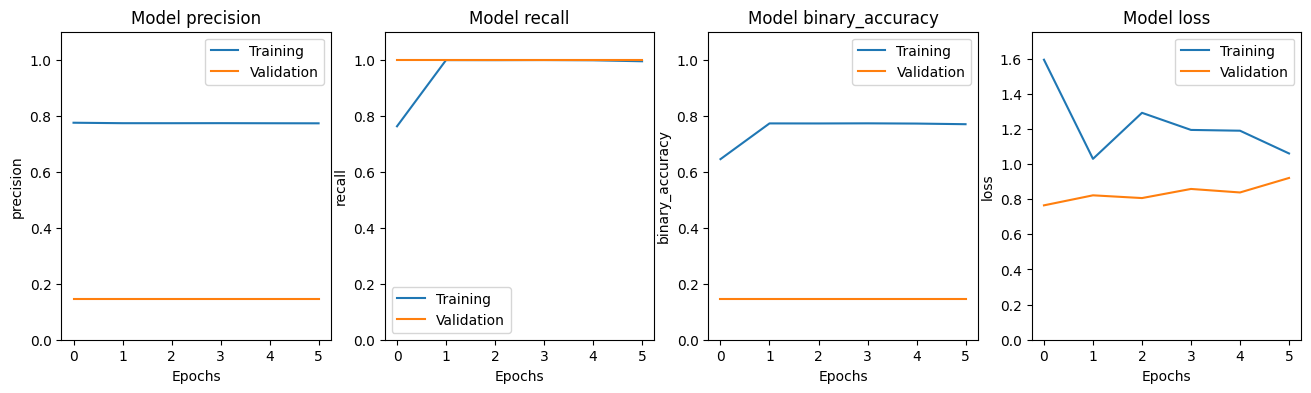

In [181]:
graph_metrics = ["precision", "recall", "binary_accuracy", "loss"]
# graph_metrics = ["binary_accuracy", "loss"]

max_loss = max(history.history["loss"])
max_val_loss = max(history.history["val_loss"])
y_max = [1, 1, 1, max(max_loss, max_val_loss)]

fig, ax = plt.subplots(1, len(graph_metrics), figsize=(16, 4))
ax = ax.ravel()

for i, metric in enumerate(graph_metrics):
    ax[i].plot(history.history[metric])
    ax[i].plot(history.history["val_" + metric])
    ax[i].set_title("Model " + metric)
    ax[i].set_xlabel("Epochs")
    ax[i].set_ylabel(metric)
    ax[i].legend(["Training", "Validation"])
    ax[i].set_ylim(ymin=0, ymax=1.1*y_max[i])


In [182]:
# Reload best model
best_model = keras.models.load_model(checkpoint_filepath)

In [183]:
validation_predictions = model.predict(X_validation)
validation_prediction_labels = [round(item[0]) for item in validation_predictions.tolist()]


conf_matrix = confusion_matrix(list(Y_validation), validation_prediction_labels, labels=[False, True])

recall_true = conf_matrix[1][1] / (conf_matrix[1][0] + conf_matrix[1][1])
precision_true = conf_matrix[1][1] / (conf_matrix[0][1] + conf_matrix[1][1])
F1_true = 2 * ( (precision_true * recall_true) / (precision_true + recall_true) )

correct_vals = conf_matrix[0][0] + conf_matrix[1][1]
incorrect_vals = conf_matrix[0][1] + conf_matrix[1][0]
accuracy = correct_vals / (correct_vals + incorrect_vals)

print("Correctly predicted labelss: ", correct_vals)
print("Incorrectly predicted labelss: ", incorrect_vals)
print("Model's accuracy: ", accuracy)
print("Model's recall: ", recall_true)
print("Model's precision: ", precision_true)
print("Model's F1 score: ", F1_true)

2460/2460 [==============================] - 2s 959us/step
Correctly predicted labelss:  11532
Incorrectly predicted labelss:  67167
Model's accuracy:  0.14653299279533413
Model's recall:  1.0
Model's precision:  0.14653299279533413
Model's F1 score:  0.2556105994613825


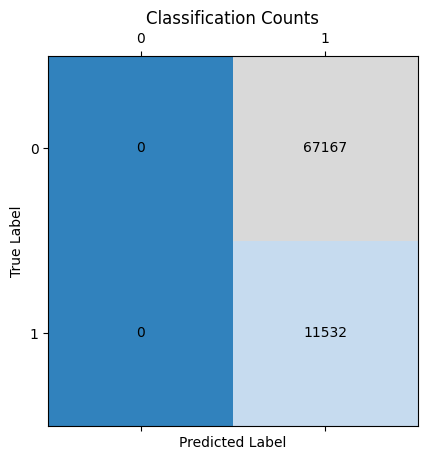

In [184]:
# Plot confusion Matrix
fig, ax = plt.subplots()
ax.matshow(conf_matrix, cmap='tab20c')

# Print classification counts within matrix boxes
for i in range(len(conf_matrix)):
   for j in range(len(conf_matrix[0])):
      c = conf_matrix[j, i]
      ax.text(i, j, str(c), va='center', ha='center')

# Set plot axis titles and show plot
ax.set_xlabel('Predicted Label')
ax.set_ylabel('True Label')
ax.set_title('Classification Counts')
plt.show()

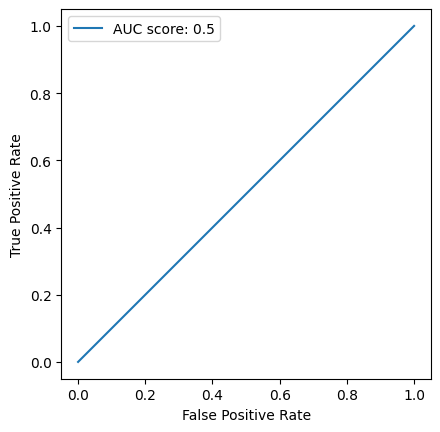

In [185]:

from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

# Calculate scores for testing dataset
fpr, tpr, thresholds = roc_curve(list(Y_validation), validation_prediction_labels)

# Calculate AUC score
auc_score = roc_auc_score(list(Y_validation), validation_prediction_labels)

# Print ROC plot
plt.plot(fpr, tpr,)
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(["AUC score: " + str(round(auc_score, 5))], loc="best")
plt.show()